In [1]:
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from os.path import join, isdir, dirname, abspath
from os import listdir
from typing import List
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl


root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)

from prochain_transformer.subroutines.eval_sweeps import get_df_recursive, has_logs_subfolder, get_df_kfold_loss
from prochain_transformer.predict import get_features_gradients

In [2]:
dirpath = "../experiments/training/dx_250618_sum"

In [4]:
df_loss = get_df_recursive(filepath=dirpath, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)
df_loss.head()

,k,val_loss,train_loss,test_loss,level_3,level_2,level_1,level_0
0,k_0,0.007662,0.000402,0.000482,sweep_d_ff_10,sweep_d_ff,sweeps,mod100
1,k_1,0.005159,0.000239,0.000566,sweep_d_ff_10,sweep_d_ff,sweeps,mod100
2,k_2,0.008717,0.000343,0.004105,sweep_d_ff_10,sweep_d_ff,sweeps,mod100
3,k_3,0.007904,0.000170,0.003993,sweep_d_ff_10,sweep_d_ff,sweeps,mod100
4,k_4,0.005754,0.000404,0.004446,sweep_d_ff_10,sweep_d_ff,sweeps,mod100


In [25]:
columns_name_map = {
    "val_loss"  : "validation",
    "train_loss"  : "train",
    "test_loss"  : "test",
    "level_2": "sweep variable"
    }

compound_cols = [
        {
            "old_label":"level_3", 
            "new_label":"sweep value", 
            "regex":r"(\d+)$", 
            "type":float
            },
        {
            "old_label" :"level_0",
            "new_label": "model base",
            "regex":r"(\d+)$", 
            "type":float}
        ]

columns_to_dump = [
    "level_0",
    "level_1",
    "level_3"
]

def post_process_sweep(
    df: pd.DataFrame,
    compound_cols: List[dict],
    columns_name_map: dict=None,
    columns_to_dump: list=None
    ):
    
    df_ = df.copy()
    
    # extract sweeps and base info
    for compound_col in compound_cols:
        df_[compound_col["new_label"]] = df_[compound_col["old_label"]].str.extract(compound_col["regex"])
        df_[compound_col["new_label"]] = df_[compound_col["new_label"]].astype(compound_col["type"])
        
    if columns_name_map is not None:
        df_ = df_.rename(columns=columns_name_map)
        
    if columns_to_dump is not None:
        df_ = df_.drop(columns=columns_to_dump)
        
    return df_

df = post_process_sweep(df_loss, compound_cols, columns_name_map, columns_to_dump)
print(df["sweep variable"].unique())
df.head()

['sweep_d_ff' 'sweep_d_model_set' 'sweep_d_qk']


,k,validation,train,test,sweep variable,sweep value,model base
0,k_0,0.007662,0.000402,0.000482,sweep_d_ff,10.0,100.0
1,k_1,0.005159,0.000239,0.000566,sweep_d_ff,10.0,100.0
2,k_2,0.008717,0.000343,0.004105,sweep_d_ff,10.0,100.0
3,k_3,0.007904,0.000170,0.003993,sweep_d_ff,10.0,100.0
4,k_4,0.005754,0.000404,0.004446,sweep_d_ff,10.0,100.0


<Axes: xlabel='sweep value', ylabel='validation'>

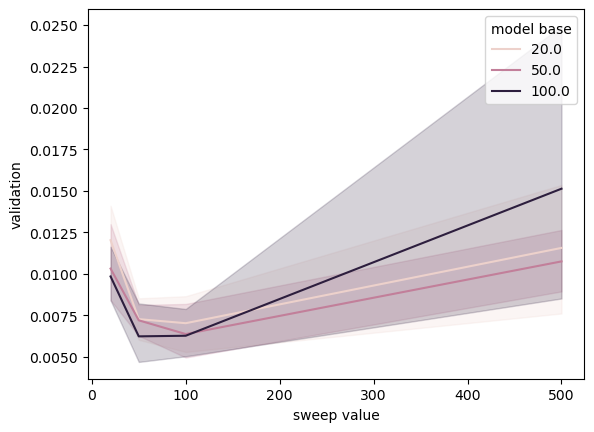

In [19]:
df_plot = df.set_index(["sweep variable"]).loc["sweep_d_model_set"].fillna(value=0)

sns.lineplot(df_plot, x="sweep value",y="validation", hue="model base")
#plt.xscale("log")

Consider the optimal $d_\text{emb}^\star=100$ it seems that $d_\text{emb}^\star\perp d_\text{model}$ 

<Axes: xlabel='dimension delta', ylabel='validation'>

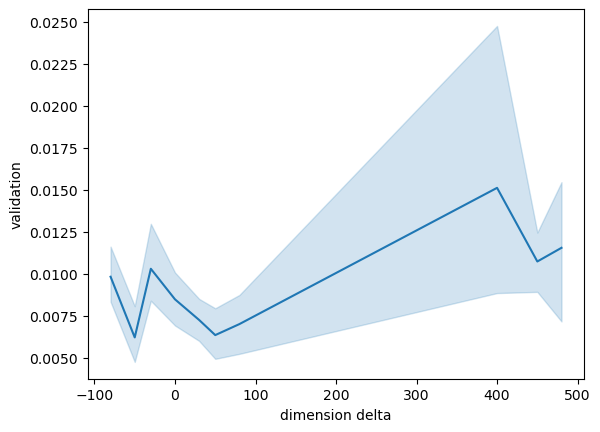

In [23]:
df_plot["dimension delta"] = -df_plot["model base"]+df_plot["sweep value"]
sns.lineplot(df_plot, x="dimension delta",y="validation")